In [ ]:
!pip install tensorflow==1.15.3
!pip install h5py==2.10.0
!pip install tensorflow-gpu==1.15.3
!pip install -U scikit-image==0.16.2
!pip install keras==2.1.5

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN
!python setup.py install

In [ ]:
import os
import sys
import matplotlib.pyplot as plt
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN")
sys.path.append(ROOT_DIR)  
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_instances,display_instances_video,apply_mask
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
import matplotlib.image as mpimg
import json
import cv2

Using TensorFlow backend.


In [ ]:
def get_ax(rows=1, cols=1, size=10):
  "Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax

In [ ]:
class InferenceConfig(Config):
  NAME = "object"
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1
  DETECTION_MIN_CONFIDENCE = 0.7
  NUM_CLASSES = 1 + 1 
  STEPS_PER_EPOCH = 100
config = InferenceConfig()

In [ ]:
model = modellib.MaskRCNN(mode="inference", model_dir='/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN/logs', config=config)

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Mask_RCNN/logs/object20221012T0827/mask_rcnn_object_0003.h5', by_name=True)

Re-starting from epoch 3


In [ ]:
class FootballDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "Ball")
       
        assert subset in ["train", "valid"]

        dataset_dir = os.path.join(dataset_dir, subset)
        annotations_temp = json.load(open(os.path.join(dataset_dir, "annotations.json")))
        annotations = list(annotations_temp.values()) 
        annotations = [a for a in annotations if a['regions']]
        

        for a in annotations:
            polygons=[]
            objects=[]
            temp_1 = a['regions'].values()
            for temp_2 in temp_1:
              polygons.append(temp_2['shape_attributes'])
              objects.append(temp_2['region_attributes']['label'])

            num_ids = [1 for a in objects]
            image_path = os.path.join(dataset_dir, a['filename'])
            image = cv2.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  
                image_id=a['filename'],  
                path=image_path,
                width=width+1, height=height+1,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]

        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
      
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids 

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
dataset = FootballDataset()
dataset.load_custom("/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Datasets", "valid")
dataset.prepare()

1
Processing 1 images
image                    shape: (418, 800, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[1]


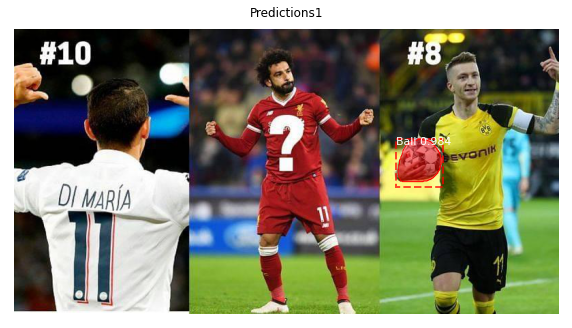

In [ ]:

image1 = mpimg.imread('/content/drive/MyDrive/Colab Notebooks/Football Detection Mask RCNN/Datasets/test/61.jpg')
# Run object detection
print(len([image1]))
results1 = model.detect([image1], verbose=1)
# Display results
ax = get_ax(1)
r1 = results1[0]
print(r1['class_ids'])
display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],dataset.class_names,
                  r1['scores'], ax=ax, title="Predictions1")